In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt



# 1. Prepare the data

In [ ]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

print(train.info())

print(test.info())

print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

1.1: Here, I read the datasets into dataframes, changed the index to the date, and looked at the data. All the data except the date indexes appear to be floats, and there are fewer columns in the test set than in the other two. There are a lot of missing values throughout the data.

In [ ]:
train['recovery_calculated'] = ((train['rougher.output.concentrate_au']*(train['rougher.input.feed_au']-train['rougher.output.tail_au']))/(train['rougher.input.feed_au']*(train['rougher.output.concentrate_au']-train['rougher.output.tail_au'])))* 100

train_no_na = train.dropna()

print('MAE:', mean_absolute_error(train_no_na['recovery_calculated'], train_no_na['rougher.output.recovery']))

MAE: 9.555596961987514e-15


1.2: Here, I calculated the recovery based on the formula we were given with the different columns in the train dataset for the flotation stage. Then I calculated the mean absolute error between these calculations and their values, and found that it is very close to 0, confirming that the recovery is calculated correctly. Since I haven't preprocessed the data yet, I had to dropna for the MAE function to work, but this should still be enough to confirm the calculations.

1.3: I then looked back at the column names for the train and test sets and determined the columns that aren't given in the test set, which are all of the output values for each stage plus some called rougher.calculation, which seem to be calculating ratios of different components. These are likely not in the test set because they are measurements for observation as opposed to measurements that would affect the gold amounts and so shouldn't be used in the model.

In [ ]:
train = train.fillna(0)
test = test.fillna(0)
full = full.fillna(0)

1.4: 

- The datatypes are fine, but there are plenty of missing values in all the datasets. I chose to fill them all in with 0 because most of them are measurements of chemicals that probably are just not present in the sludge if there's a missing value. If this isn't the case for some columns, the number of missing values is small enough compared to the filled values for it not to affect the model's performance too much.  

# 2. Analyze the data

In [ ]:
print('Silver:', full['rougher.input.feed_ag'].mean(), '-->',
full['rougher.output.concentrate_ag'].mean(), '-->',
full['primary_cleaner.output.concentrate_ag'].mean(), '-->',
full['final.output.concentrate_ag'].mean())

print('Lead:', full['rougher.input.feed_pb'].mean(), '-->',
full['rougher.output.concentrate_pb'].mean(), '-->',
full['primary_cleaner.output.concentrate_pb'].mean(), '-->',
full['final.output.concentrate_pb'].mean())

print('Gold:', full['rougher.input.feed_au'].mean(), '-->', 
full['rougher.output.concentrate_au'].mean(), '-->',
full['primary_cleaner.output.concentrate_au'].mean(), '-->',
full['final.output.concentrate_au'].mean())

Silver: 8.030918721075652 --> 10.827569702119838 --> 7.658468903190332 --> 4.762825572878352
Lead: 3.270168463586653 --> 6.870875872633261 --> 8.745169657099943 --> 9.060473988300497
Gold: 7.532864611680439 --> 17.802403375427513 --> 29.086262804482388 --> 39.8497323475366


2.1 I used the full dataset and got the mean concentrations of all the metals at each output stage and the raw feed. I found that the amount of silver decreased while the amount of lead increased, but gold had the most dramatic increase and ended up having 5 times higher concentration than the raw input.

Training:


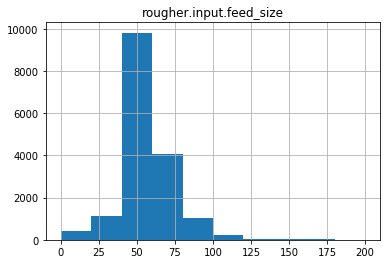

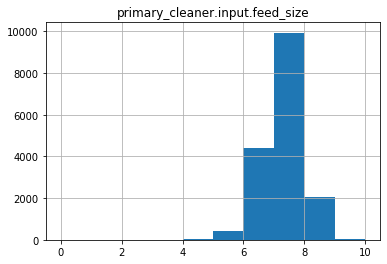

Test:


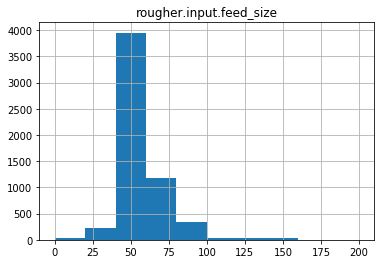

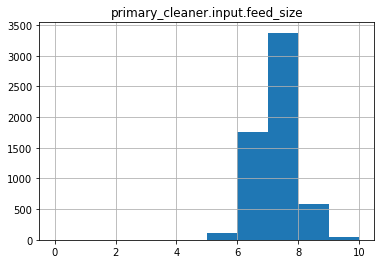

In [ ]:
print('Training:')
train.hist('rougher.input.feed_size', range=[0, 200])
plt.show()
train.hist('primary_cleaner.input.feed_size', range=[0, 10])
plt.show()

print('Test:')
test.hist('rougher.input.feed_size', range=[0, 200])
plt.show()
test.hist('primary_cleaner.input.feed_size', range=[0, 10])
plt.show()

2.2. As we can see from the histograms, in both stages the feed size distributions are quite similar, which means they won't throw off the model.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efed6d72050>]],
      dtype=object)

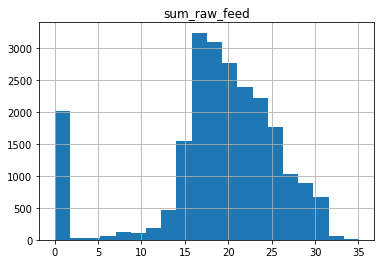

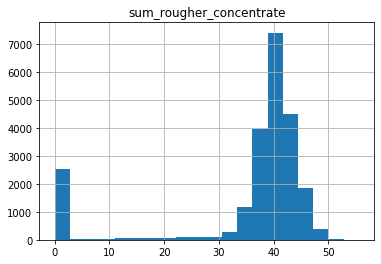

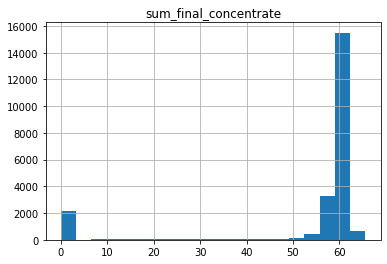

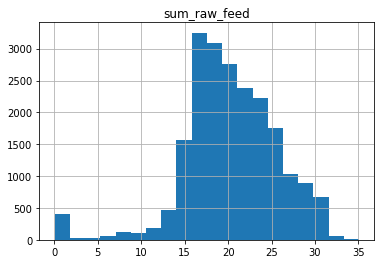

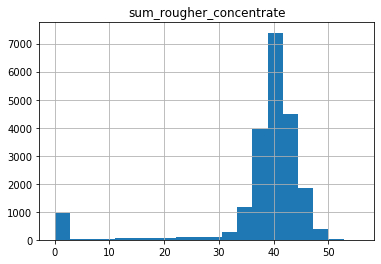

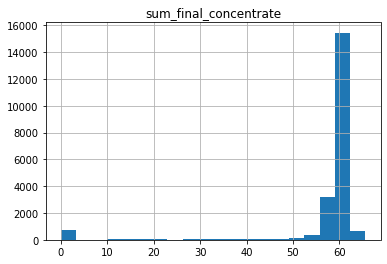

In [ ]:
full['sum_raw_feed'] = full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] + full['rougher.input.feed_au']
full['sum_rougher_concentrate'] = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_au']
full['sum_final_concentrate'] = full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] + full['final.output.concentrate_au']

full.hist('sum_raw_feed', bins=20)
full.hist('sum_rougher_concentrate', bins=20)
full.hist('sum_final_concentrate', bins=20)

train['sum_raw_feed'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] + train['rougher.input.feed_au']
test['sum_raw_feed'] = test['rougher.input.feed_ag'] + test['rougher.input.feed_pb'] + test['rougher.input.feed_au']

train = train[train['sum_raw_feed'] > 0]
test = test[test['sum_raw_feed'] > 0]
full = full[full['sum_raw_feed'] > 0]

full.hist('sum_raw_feed', bins=20)
full.hist('sum_rougher_concentrate', bins=20)
full.hist('sum_final_concentrate', bins=20)

2.3. The histograms show there are a lot of entries with very close to zero for all concentrations, which could be because I filled all the missing values with zeroes. I decided to remove all entries with the rougher.input.feed concentrations 0 from all the datasets. I then ran the histograms again and the peaks near 0 were reduced.

# 3. Build the model

In [ ]:
#columns to drop from the training features
drop_columns = ['date', 'recovery_calculated', 'sum_raw_feed',
                'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au',
               'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 
                'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio',
               'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au',
               'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au']

features = train.drop(drop_columns, axis=1)
target = train[['rougher.output.recovery', 'final.output.recovery']]

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

features_test = test.drop(['date', 'sum_raw_feed'], axis=1)
target_test = test.merge(full, on='date', how='left')[['rougher.output.recovery', 'final.output.recovery']]

print(features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(11714, 52) (11714, 2) (3905, 52) (3905, 2) (5471, 52) (5471, 2)


I then created the train, valid, and test features and targets. 

- To split the training set into train and valid, I first dropped all the columns not in the test dataset, plus the date and the recovery_calculated from the last step, making that the features, and got the two columns we need to predict for the target, then split those using train_test_split.  
- For the test set, the features are what's in the test dataset minus the date. I got the target from the full dataset by merging them on the date column, keeping only the entries present in the test dataset and selecting only the columns we need to predict. I then printed the shapes of everything to make sure they matched.

In [ ]:
def smape(prediction, target):
    sum_values = (abs(target - prediction))/((abs(target)+abs(prediction))/2)
    return sum_values.mean() * 100 

def total_smape(rougher_prediction, rougher_target, final_prediction, final_target):
    return (0.25 * smape(rougher_prediction, rougher_target)) + (0.75 * smape(final_prediction, final_target))

3.1 Here I defined a function to calculate the sMAPE for a prediction and target series, and a function that makes use of that one to calculate the total sMAPE given series of the rougher and final values.

In [ ]:
#Decision tree
for n in range (1, 20):
    model = DecisionTreeRegressor(max_depth=n, random_state=12345)

    model.fit(features_train, target_train['rougher.output.recovery'])
    predictions_rougher = model.predict(features_valid)

    model.fit(features_train, target_train['final.output.recovery'])
    predictions_final = model.predict(features_valid)
    
    print(total_smape(predictions_rougher, target_valid['rougher.output.recovery'], predictions_final, target_valid['final.output.recovery']))

19.060850537268117
18.98249940676926
18.29674468642792
17.735545535457085
17.565005060533736
16.030152055617886
15.88419642641886
14.962392126573086
15.042773467885599
14.907407041881758
14.905190366110475
14.60199119874756
14.171323543516134
14.346840721550457
14.59654445084426
13.816142703313197
14.00823794703679
14.152917410345053
13.966460418908794


In [ ]:
#Random forest
model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=12345)

model.fit(features_train, target_train['rougher.output.recovery'])
predictions_rougher = model.predict(features_valid)

model.fit(features_train, target_train['final.output.recovery'])
predictions_final = model.predict(features_valid)

print(total_smape(predictions_rougher, target_valid['rougher.output.recovery'], predictions_final, target_valid['final.output.recovery']))

15.644686239651351


In [ ]:
#Linear regression
model = LinearRegression()

model.fit(features_train, target_train['rougher.output.recovery'])
predictions_rougher = model.predict(features_valid)

model.fit(features_train, target_train['final.output.recovery'])
predictions_final = model.predict(features_valid)

print(total_smape(predictions_rougher, target_valid['rougher.output.recovery'], predictions_final, target_valid['final.output.recovery']))

18.48734045715465


In [ ]:
#Testing on test set
model = DecisionTreeRegressor(max_depth = 5, random_state=12345)

model.fit(features_train, target_train['rougher.output.recovery'])
predictions_rougher = model.predict(features_test)

model.fit(features_train, target_train['final.output.recovery'])
predictions_final = model.predict(features_test)

print(total_smape(predictions_rougher, target_test['rougher.output.recovery'], predictions_final, target_test['final.output.recovery']))

14.425815505266588


3.2 I then tried different models on the training and validation sets to try to get the lowest sMAPE. I did this by training the model on one of the targets at a time, then combining those predictions into the final sMAPE function. I tried various depths for the decision tree, but only one variation of the random forest due to the long runtime. I found that a decision tree regressor with a max depth of 16 worked well with a sMAPE of 13.8 so that's what I used in the final test on the test set, which had a sMAPE of 29. That was bigger than I wanted and it was probably from overfitting, so I decreased the max depth to 6 and the sMAPE decreased to 14.4

### Conclusion

We have been able to predict the amount of gold we can get out of ore with machine learning models.